<a href="https://colab.research.google.com/github/ahsanabbas123/Neural-Machine-Translation/blob/master/NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and Preparing data

In [0]:
# Requirements

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Lang helper class

SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0 : "SOS", 1 : "EOS"}
    self.n_words = 2
  
  def addWord(self, word):
    if word in self.word2index:
      self.word2count[word] += 1
    else:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
'''Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences.
Here the maximum length is 10 words (that includes ending punctuation) 
and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier). '''

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [0]:
'''
The full process for preparing the data is:

Read text file and split into lines, split lines into pairs
Normalize text, filter by length and content
Make word lists from sentences in pairs

'''

def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
      input_lang.addSentence(pair[0])
      output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  
  return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))




Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['c est un esprit independant .', 'he s an independent thinker .']


## Seq2Seq Model

In [0]:
# Encoder 

class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, self.hidden_size)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1,1,-1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# Decoder With Attention

class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, n_layers=1, max_length = MAX_LENGTH, p_dropout=0.1):
    super(AttnDecoderRNN, self).__init__()
    # params
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.p_dropout = p_dropout
    self.max_length = max_length

    # layers
    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.dropout = nn.Dropout(self.p_dropout)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(2 * self.hidden_size, self.hidden_size)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_ouputs):
    embedded = self.embedding(input).view(1,1,-1)
    embedded = self.dropout(embedded)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]),1)), dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_ouputs.unsqueeze(0))

    output = self.attn_combine(torch.cat((embedded[0],attn_applied[0]),1)).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = self.out(output)
    output = F.log_softmax(output[0], dim=1)
    return output, hidden, attn_weights
  
  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

# Training

In [0]:
# Preparing training data 

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) 

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

In [0]:
#  for one iteration i.e one input-output pair
# adding teacher forcing for quicker convergence

teacher_force_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):

  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

  decoder_hidden = encoder_hidden
  decoder_input = torch.tensor([[SOS_token]], device=device)

  use_teacher_forcing =  True if random.random() < teacher_force_ratio else False 
  
  if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing
  else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach() # detach history from input :: why? DOUBT!!!!
      
      loss += criterion(decoder_output, target_tensor[di])

      if decoder_input.item() == EOS_token:
        break
  
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length


In [0]:
import math
import time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every = 1000, plot_every=100, learning_rate=0.01):

  start = time.time()
  plot_losses = []
  print_loss_total = 0  
  plot_loss_total = 0 

  encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)

  training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

  criterion = nn.NLLLoss()

  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
    
    if iter % plot_every == 0: 
      plot_losses.append(plot_loss_total / plot_every)
      plot_loss_total = 0
  
  showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

6m 45s (- 94m 40s) (5000 6%) 2.8522
13m 35s (- 88m 20s) (10000 13%) 2.2614
20m 22s (- 81m 29s) (15000 20%) 1.9970
26m 56s (- 74m 5s) (20000 26%) 1.7066
33m 19s (- 66m 39s) (25000 33%) 1.5281
40m 25s (- 60m 38s) (30000 40%) 1.3736
47m 2s (- 53m 45s) (35000 46%) 1.2194
53m 35s (- 46m 53s) (40000 53%) 1.0862
60m 18s (- 40m 12s) (45000 60%) 0.9934
66m 51s (- 33m 25s) (50000 66%) 0.9064
73m 37s (- 26m 46s) (55000 73%) 0.8201
80m 14s (- 20m 3s) (60000 80%) 0.7228
86m 36s (- 13m 19s) (65000 86%) 0.7060
92m 52s (- 6m 38s) (70000 93%) 0.6306
99m 18s (- 0m 0s) (75000 100%) 0.5861


> nous sommes un peu occupes ici .
= we re a little busy here .
< we re a little busy here . <EOS>

> nous sur pechons dans les oceans du monde .
= we are overfishing the world s oceans .
< we are on the the library world . <EOS>

> il est dans la mouise .
= he s in hot water .
< he s in in library . <EOS>

> j ai peur d y aller .
= i am afraid to go .
< i am afraid to go . <EOS>

> j ai peur des ours .
= i am afraid of bears .
< i m afraid of spiders . <EOS>

> il te regarde .
= he s looking at you .
< he s being watched . <EOS>

> je suis toujours marie .
= i m still married .
< i m still married . <EOS>

> vous cooperez .
= you re cooperating .
< you re overreacting . <EOS>

> vous etes charmants .
= you re charming .
< you re powerful . <EOS>

> tu es ma fille .
= you are my daughter .
< you are my daughter . <EOS>



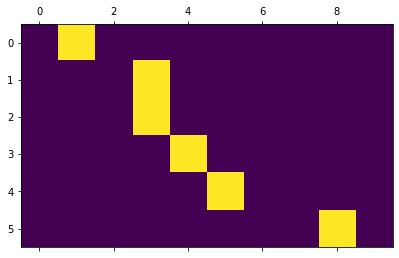

In [0]:
%matplotlib inline
evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is three years younger than me . <EOS>


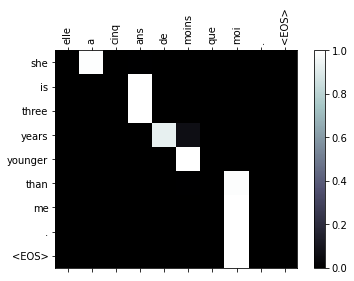

input = elle est trop petit .
output = she is too short . <EOS>


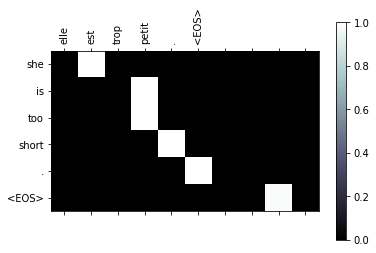

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


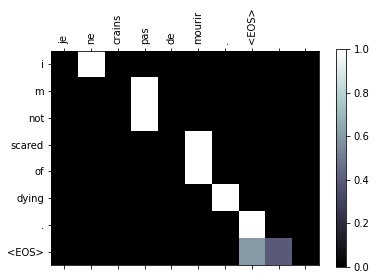

input = c est un jeune directeur plein de talent .
output = he s a talented young . <EOS>


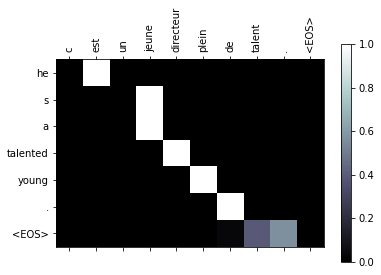

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")